Building point-distance cache
Point-distance cache built

100% |########################################################################|



Predicting for k in [1,24]
The best k found was 4, its accuracy is 92.83%
The weighted accuracy result discussed by Hassanat et al. (2014) found an accuracy of 90.67%


/Users/guydavidson/Virtualenvs/dev/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


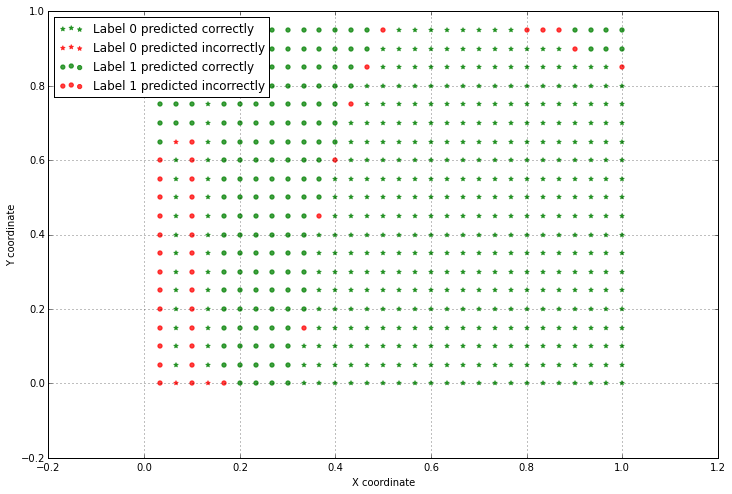

Building point-distance cache
Point-distance cache built

100% |########################################################################|



Predicting for k in [1,24]
The best k found was 11, its accuracy is 97.67%
The weighted accuracy result discussed by Hassanat et al. (2014) found an accuracy of 96.83%


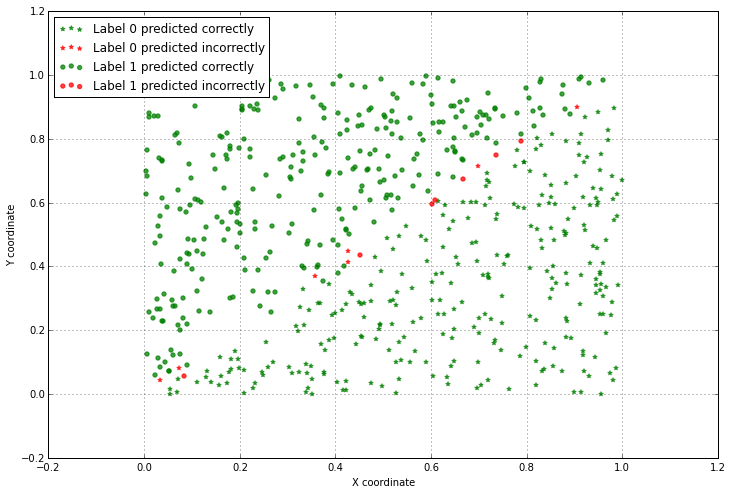

Building point-distance cache
Point-distance cache built

100% |########################################################################|



Predicting for k in [1,24]
The best k found was 11, its accuracy is 92.83%
The weighted accuracy result discussed by Hassanat et al. (2014) found an accuracy of 89.50%


ValueError: Unknown projection '3d'

In [1]:
%matplotlib inline
import numpy as np
import progressbar
import sortedcontainers
import matplotlib.pyplot as plot

# -- Constants -- #

LEARNING_SET_PATH = 'knn_data.npy'
LEARNING_SET_3D_PATH = 'knn_3d_data.npy'

TEST_DATA_PATH = 'test_knn_data.npy'
TEST_DATA_PATH_3D = 'test_knn_3d_data.npy'

CACHE_KEY_SEPARATOR = '|'
CACHE = {}

LABELS = {}


# -- Caching Wrapper -- #

def cache(ignore_order=False):
    """
    A decorator supporting caching of a function with any number of arguments
    :param ignore_order: Is the function argument-order sensitive, or not.
    :return: The same function, wrapped to cache
    """

    def cache_function(function):
        global CACHE

        if function not in CACHE:
            CACHE[function] = {}

        function_cache = CACHE[function]

        def cached_function(*args, **kwargs):
            key = ''
            # Doing some tricks here to ignore ordering
            if args:
                if ignore_order:
                    key += CACHE_KEY_SEPARATOR.join([str(arg) for arg in sorted(args)])

                else:
                    key += CACHE_KEY_SEPARATOR.join([str(arg) for arg in args])

            # Doing some tricks here to ignore ordering
            if kwargs:
                if ignore_order:
                    key += CACHE_KEY_SEPARATOR.join(
                        ['{name}:{value}'.format(name=name, value=kwargs[name]) for name in sorted(kwargs.keys())])

                else:
                    key += CACHE_KEY_SEPARATOR.join(
                        ['{name}:{value}'.format(name=name, value=kwargs[name]) for name in kwargs.keys()])


            if key in function_cache:
                return function_cache[key]

            result = function(*args, **kwargs)
            if key:
                function_cache[key] = result

            return result

        return cached_function

    return cache_function


# -- Classes -- #

class PriorityQueue(object):
    def __init__(self):
        '''
        A simple priority queue implementation, using two sorted dictionaries.
        :return:
        '''
        self.priority_to_elements = sortedcontainers.SortedDict()
        self.element_to_priority = sortedcontainers.SortedDict()


    def put(self, element, priority):
        '''
        Puts an element into the priority queue
        :param element: The element to insert. Can be anything.
        :param priority: The priority, as a number. Lowered is assumed to be better / higher priority.
        :return:
        '''
        if (element in self.element_to_priority) and (priority > self.element_to_priority[element]):
            return

        self.element_to_priority[element] = priority

        if priority not in self.priority_to_elements:
            self.priority_to_elements[priority] = []

        self.priority_to_elements[priority].append(element)


    def get_extreme_key(self, min=True):
        keys = self.priority_to_elements.keys()

        if min:
            key = keys[0]

        else:
            key = keys[len(keys) - 1]

        return key


    def get_extreme_priority(self, min=True):
        key = self.get_extreme_key(min)
        return self.priority_to_elements[key]


    def get(self, min=True):
        '''
        Removes and returns the element with the lowest priority score (by default).
        :param min: True if should return the object with the lowest priority score. False if should return the highest.
        :return: The most extremely prioritized object, base on whether the parameter min is True or False
        '''
        key = self.get_extreme_key(min)
        priority =  self.priority_to_elements[key]

        element = priority.pop()

        if not priority:
            del self.priority_to_elements[key]

        return element


    def get_many(self, count, min=True):
        return [self.get(min) for i in xrange(count)]


    def __len__(self):
        return len(self.priority_to_elements)



class Point(object):
    def __init__(self, line):
        '''
        An n-dimensional point imlementation.
        Assumes each line has n coordinates up until the last item, which is the label
        :param line: an iterable/slicable containing the values for a given datum
        :return: the Point objecy
        '''
        if len(line) < 2:
            raise ValueError('Each line must have at least one coordinate and an actual label')

        self.coordinates = line[:len(line) - 1]
        self.actual_label = line[len(line) - 1]
        self.predicted_labels = {}
        self.weighted_predicted_label = None

        global LABELS

        if not self.actual_label in LABELS:
            LABELS[self.actual_label] = 0

        LABELS[self.actual_label] += 1


    def __repr__(self):
        '''
        :return: A simple string representation of the point
        '''
        return '({coordinates}) => {label}'.format(coordinates=', '.join([str(x) for x in self.coordinates]),
                                                   label=self.actual_label)


# -- Prediction Functions -- #

# POTENTIAL_NEAREST_POINTS_HEURISTIC = 2
# def build_sorted_data_cache(data):
#     '''
#
#     :param data:
#     :return:
#     '''
#     global SORTED_DATA_CACHE
#
#     for dimension in xrange(len(data[0].coordinates)):
#         SORTED_DATA_CACHE.append(sortedcontainers.SortedList(data, key=lambda p: p.coordinates[dimension]))
#
#
# def get_potential_nearest_points(k, point):
#     '''
#
#     :param k:
#     :param point:
#     :return:
#     '''
#     global SORTED_DATA_CACHE
#     potential_nearest_points = set()
#
#     extra_items = 0
#     while len(potential_nearest_points) < POTENTIAL_NEAREST_POINTS_HEURISTIC * k:
#         for dimension in xrange(len(point.coordinates)):
#             dimension_list = SORTED_DATA_CACHE[dimension]
#             bisect_index = dimension_list.bisect(point)
#             potential_nearest_points.update(dimension_list[max(bisect_index - k - extra_items, 0) :
#                 min(bisect_index + k + extra_items, len(dimension_list))])
#
#         extra_items +=POTENTIAL_NEAREST_POINTS_HEURISTIC
#
#     if point in potential_nearest_points:
#         potential_nearest_points.remove(point)
#
#     return potential_nearest_points
#
#
# def find_nearest_neighbors(k, data, point):
#     '''
#     Find the nearest neighbors - using a sorted cache
#     :param k:
#     :param data:
#     :return:
#     '''
#     global SORTED_DATA_CACHE
#
#     if not SORTED_DATA_CACHE:
#         build_sorted_data_cache(data)
#
#     potential_nearest_points = get_potential_nearest_points(k, point)
#     distance_to_points = PriorityQueue()
#
#     for potential_nearest in potential_nearest_points:
#         distance_to_points.put(potential_nearest, distance(point, potential_nearest))
#
#     heuristic_nearest = distance_to_points.get_many(k)
#
#     all_data_dtp = PriorityQueue()
#     for p in data:
#         if p != point:
#             all_data_dtp.put(p, distance(point, p))
#
#     all_nearest = all_data_dtp.get_many(k)
#
#     print sum([distance(point, d) for d in heuristic_nearest]) - sum([distance(point, d) for d in all_nearest])
#
#     return all_nearest


def read_data(data_path):
    '''
    Read the data from the an input fle, and convert it to Point objects
    :param data_path: The path to read the .npy file from
    :return: A list of Point objects.
    '''
    with open(data_path) as data_file:
        data = np.load(data_file)

    return [Point(line) for line in data]


def build_neighbor_cache(data, max_k=None):
    '''
    Builds the cache of nearest-neighbors for each point in the data.
    :param data: The list of Points objects to build a cache for.
    :param max_k: The maximal value of k that will be considered (and hence number of nearest neighbors that must
    be cached. If None passed, caches the entire length of the data.
    :return: The cache from each Point object to tis max_k nearest neighbors.
    '''
    neighbor_cache = {}
    if not max_k:
        max_k = len(data)

    print 'Building point-distance cache'

    progress = progressbar.ProgressBar()

    for point in progress(data):
        data_for_point = data[:]
        data_for_point.remove(point)
        data_for_point.sort(key=lambda p: distance(p, point))
        neighbor_cache[point] = data_for_point[:max_k]

    print 'Point-distance cache built'

    return neighbor_cache


@cache(True)
def distance(first_point, second_point):
    '''
    The cached distance function to be called by external user.
    :param first_point: The first point to calculate distance between.
    :param second_point: The second point to calculate distance between.
    :return: The distance between them. Currently Euclidian.
    '''
    return _euclidean_distance(first_point, second_point)


def _euclidean_distance(first_point, second_point):
    '''
    n-dimensional implementation of the euclidean distance formula - the square root of the sum of the squares
    of the differences in each dimension.
    :param first_point: The first point to calculate distance between.
    :param second_point: The second point to calculate distance between.
    :return: The Euclidean distance between the two points.
    '''
    return sum(map(lambda pair: (pair[0] - pair[1]) ** 2,
                   zip(first_point.coordinates, second_point.coordinates))) ** 0.5


def _grid_distance(first_point, second_point):
    '''
    An alternative distance function, an n-dimensional 'city grid' distance measurements - the sum of the differences
    in each dimension.
    :param first_point: The first point to calculate distance between.
    :param second_point: The second point to calculate distance between.
    :return: The 'city grid' distance between the two points.
    '''
    return sum(map(lambda pair: (pair[0] - pair[1]),
                   zip(first_point.coordinates, second_point.coordinates)))


def label_point(point, k, k_nearest):
    '''
    Predict the labeling of a point based on its k nearest neighbors. In case of a tie, choose the label whose
    sums of distances are lower.
    :param point: The point currently being labeled
    :param k: The current k treated
    :param k_nearest: The k closest points to the current point.
    :return: None, but mark the point labeled in its predicted_labels member for the given k.
    '''
    global LABELS

    potential_labels = PriorityQueue()

    for label in LABELS:
        potential_labels.put(label, len([p for p in k_nearest if p.actual_label == label]))

    top_labels = potential_labels.get_extreme_priority(False)

    if len(top_labels) == 1:
        point.predicted_labels[k] = top_labels[0]

    else:
        # Resolve ties by lowest sum of distances
        top_labels.sort(key=lambda l: sum([distance(point, p) for p in k_nearest if p.actual_label == label]))
        point.predicted_labels[k] = top_labels[0]


def predict_labels(k, data, neighbor_cache):
    '''
    Go through all data points, and predict the label given a specific k
    :param k: the k to currently consider
    :param data: the data (some iterable data structure including points)
    :return:
    '''
    if not (0 < k < len(data)):
        raise ValueError('Invalid k specified. k | 0 < k < len(data)')

    for point in data:
        k_nearest = neighbor_cache[point][:k]
        label_point(point, k, k_nearest)


def calculate_accuracy(k, data):
    '''
    A simple accuracy calculation - for a given k, check how many points were correctly predicted.
    :param k: The k to return the accuracy for.
    :param data: All data points after being predicted for the given k
    :return: The labeling accuracy as a precentage.
    '''
    correct = [p for p in data if p.predicted_labels[k] == p.actual_label]
    return float(len(correct)) / len(data) * 100


def inverse_log_weight(k):
    '''
    The inverse log weighing function as suggested by Hassant et al. (2014).
    :param k: The k to return a weight for.
    :return: The weight for that k
    '''
    return 1.0 / np.log2(1 + k)


def calculate_weighted_predicted_labels(data):
    '''
    Weighted KNN predicted labeling, implemented from the ideas in Hassant et al. (2014).
    :param data: The data, after predicting labeling for all values of k that will be treated
    :return: The accuracy (in percentage) of the labels predicted by weighing the individual k results.
    '''
    global LABELS

    for point in data:
        labels_to_ks = {}
        for label in LABELS:
            labels_to_ks[label] = []

        predicted = point.predicted_labels
        for k in predicted:
            labels_to_ks[predicted[k]].append(k)

        weighted_label_pq = PriorityQueue()
        for label in LABELS:
            weighted_label_pq.put(label, sum([inverse_log_weight(k) for k in labels_to_ks[label]]))

        point.weighted_predicted_label = weighted_label_pq.get(False)


    correct = [p for p in data if p.weighted_predicted_label == p.actual_label]
    return float(len(correct)) / len(data) * 100


def predict_and_print_accuracy(data, min_k, max_k, neighbor_cache):
    '''
    A wrapper function, checking a range of k values [min_k, max_k] inclusive on both ends, and comparing the
    best individual result to the weighted prediction proposed by Hassant et al. (2014).
    :param data: The data to iterate through k values on and labels based on the nearest neighbors.
    :param min_k: The minimal k value to check, at least one.
    :param max_k: The maximal k value to check, at most the length of the data.
    :param neighbor_cache: The cache of at least max_k nearest neighbors to each point in the data
    :return: The top k value found for this data set.
    '''
    top_k = 0
    top_accuracy = 0

    if min_k < 1:
        print 'Minimum k {min_k} is too low. Using 1 instead.'.format(min_k=min_k)
        min_k = 1

    data_length = len(data)
    if max_k > data_length:
        print 'Maximum k {max_k} is too high. Using {data_length} (the length of the data) instead'.format(
            max_k=max_k, data_length=data_length)
        max_k = data_length

    print 'Predicting for k in [{min},{max}]'.format(min=min_k, max=max_k)

    progress = progressbar.ProgressBar()

    for k in progress(xrange(min_k, max_k+1)):
        predict_labels(k, data, neighbor_cache)
        accuracy = calculate_accuracy(k, data)
        # print 'For k = {k}, the prediction accuracy is {accuracy:2.2f}%'.format(k=k, accuracy=accuracy)

        if accuracy > top_accuracy:
            top_accuracy = accuracy
            top_k = k

    print 'The best k found was {k}, its accuracy is {accuracy:2.2f}%'.format(k=top_k, accuracy=top_accuracy)

    weighted_accuracy = calculate_weighted_predicted_labels(data)
    print 'The weighted accuracy result discussed by Hassanat et al. (2014) found an accuracy of {accuracy:2.2f}%'\
        .format(accuracy=weighted_accuracy)

    return top_k

def predict_and_graph(data_path):
    '''
    A second wrapper function, wrapping the entire treatment of a single data file:
     Read it into an array of points
     Build a nearest neighbor cache
     Predict the results
     Graph the best prediction
    :param data_path: The path of the .npy file to read data from
    :return: None
    '''
    data = read_data(data_path)
    min_k = 1
    max_k = int(len(data)**0.5)

    neighbor_cache = build_neighbor_cache(data, max_k)
    best_k = predict_and_print_accuracy(data, min_k, max_k, neighbor_cache)
    graph_prediction_results(data, best_k)


# -- Graphing Functions -- #

TWO_D = 2
THREE_D = 3
SUPPORTED_DIMENSIONS = (TWO_D, THREE_D)

DEFAULT_HORIZONTAL_SIZE = 12
DEFAULT_VERTICAL_SIZE = 8
DEFAULT_DPI = 400
DEFAULT_MARKER_SIZE = 4
DEFAULT_ALPHA = 0.75

MARKER_OPTIONS = ['s', 'D', 'x', '8', '*']
SUCCESS_COLOR = 'green'
FAILURE_COLOR = 'red'
COLOR_OPTIONS = {True: SUCCESS_COLOR, False:FAILURE_COLOR}


def plot_single_series(axes, data_dict, label, marker, is_correct, dimension=TWO_D):
    '''
    Plot a single series. Accepts both 2D and 3D data.
    :param axes: The axes (matplotlib) to plot on)
    :param data_dict: The dictionary from a each label to the to its data points.
    :param label: The current label being graphed.
    :param marker: Which marker to use for this label.
    :param is_correct: Are these the points that were predicted correctly or incorrectly?
    :param dimension: Is it 2D or 3D data? Defaults to 2D
    :return: None, but graphs the data as a scatter plot on the given exes.
    '''
    data_list = data_dict[label]

    if dimension == TWO_D:
        axes.scatter([p.coordinates[0] for p in data_list], [p.coordinates[1] for p in data_list],
            label='Label {label} predicted {status}'.format(label=str(int(label)), status=(is_correct and 'correctly' or 'incorrectly')),
            color=COLOR_OPTIONS[is_correct], marker=marker, alpha=DEFAULT_ALPHA)

    else:
        # == 3
        axes.scatter([p.coordinates[0] for p in data_list], [p.coordinates[1] for p in data_list],
            [p.coordinates[2] for p in data_list],
            label='Label {label} predicted {status}'.format(label=str(int(label)), status=(is_correct and 'correctly' or 'incorrectly')),
            color=COLOR_OPTIONS[is_correct], marker=marker, alpha=DEFAULT_ALPHA)




def graph_prediction_results(data, k):
    '''
    Graphs the results of the knn prediction in the data for the given k
    :param data: The data, after predicting labels using KNN, at least for the k value given.
    :param k: The k value chosen to graph.
    :return: None, displays a graph
    '''
    data_dimensions = len(data[0].coordinates)

    if not data_dimensions in SUPPORTED_DIMENSIONS :
        raise ValueError('Graphing is currently only supported for 2D or 3D data...')

    global LABELS

    accurate_data = {}
    missed_data = {}

    for label in LABELS:
        accurate_data[label] = []
        missed_data[label] = []

    for p in data:
        label = p.actual_label

        if label == p.predicted_labels[k]:
            accurate_data[label].append(p)

        else:
            missed_data[label].append(p)

    if data_dimensions == TWO_D:
        figure, axes = plot.subplots()

    else:
        # == 3
        figure = plot.figure()
        axes = figure.add_subplot(111, projection='3d')

    figure.set_size_inches(DEFAULT_HORIZONTAL_SIZE, DEFAULT_VERTICAL_SIZE)
    figure.set_dpi(DEFAULT_DPI)

    markers = MARKER_OPTIONS[:]

    for label in LABELS:
        marker = markers.pop()
        plot_single_series(axes, accurate_data, label, marker, True, data_dimensions)
        plot_single_series(axes, missed_data, label, marker, False, data_dimensions)

    axes.set_xlabel('X coordinate')
    axes.set_ylabel('Y coordinate')
    if data_dimensions == THREE_D:
        axes.set_zlabel('Z coordinate')

    axes.legend(loc='upper left')
    axes.grid(True)

    plot.show()

# -- Main -- #


def main():
    '''
    Runs the routine on each of the four data sets - learning/test, 2D/3D.
    :return: None
    '''
    predict_and_graph(LEARNING_SET_PATH)
    predict_and_graph(TEST_DATA_PATH)
    predict_and_graph(LEARNING_SET_3D_PATH)
    predict_and_graph(TEST_DATA_PATH_3D)


if __name__ == '__main__':
    main()


In [ ]:
main()


In [ ]:
main()

In [ ]:
data